In [ ]:
install.packages(c("readr", "dplyr", "ggplot2", "GGally", "caTools", "UBL", "xgboost", "caret", "pROC"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘wk’, ‘diagram’, ‘lava’, ‘classInt’, ‘s2’, ‘units’, ‘xts’, ‘intervals’, ‘abind’, ‘prodlim’, ‘patchwork’, ‘BH’, ‘zoo’, ‘sf’, ‘sftime’, ‘spacetime’, ‘stars’, ‘FNN’, ‘reshape’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘ggstats’, ‘plyr’, ‘bitops’, ‘MBA’, ‘gstat’, ‘automap’, ‘sp’, ‘randomForest’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘reshape2’




In [ ]:
# 1. Import libraries
library(readr)
library(dplyr)
library(ggplot2)
library(GGally) # For ggpairs
library(caTools) # For train-test split
library(UBL)     # For SMOTE (SmoteClassif function)
library(xgboost)
library(caret)   # For confusionMatrix
library(pROC)    # For AUC, though not explicitly in Python, good to have
# Set seed for reproducibility
set.seed(42)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: MBA

Loading required package: gstat

Loading required package: automap

Loading required package: sp

Loading required package: randomForest

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [ ]:
# 2. Load data
# Assuming 'drought_data.csv' is in your working directory
df <- read_csv('/drought_data.csv')


Rows: 6470 Columns: 79
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): L0_NAME, L1_NAME, L2_NAME, L3_NAME, L4_NAME, ID, NAME, MAIN_CRO_1
dbl (70): Excel_ID, Y_COORD, X_COORD, L4_CODE, L0_CODE, L1_CODE, L2_CODE, L3...
lgl  (1): DISPUTE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# 3. Basic Info
print(paste("Shape:", paste(dim(df), collapse = " x ")))
print("Null values:")
print(sapply(df, function(x) sum(is.na(x))))


[1] "Shape: 6470 x 79"
[1] "Null values:"
  Excel_ID    Y_COORD    X_COORD    L4_CODE    L0_CODE    L0_NAME    L1_CODE 
         0          0          0          0          0          0          0 
   L1_NAME    L2_CODE    L2_NAME    L3_CODE    L3_NAME    L4_NAME         ID 
         0          0          0          0          0          0          0 
   DISPUTE  unique_ID      lat44     long44      STATE VIL_CODE_P       NAME 
         0          0          0          0          0          0          0 
     No_HH      TOT_P 2011_No_HH 2011_TOT_P NET_SOWN_L UNIRRIGATE IRRIGATED_ 
         0          0          0          0          0          0          0 
  AREA_KM2 PERC_AGRI_ PERC_IRRI_ MAIN_CROP_ MAIN_CRO_1 2001_TOTAL 2001_PERC_ 
         0          0          0          0          0          0          0 
2011_TOTAL 2011_PERC_ PPT_CHANGE 1998-06-01 1998-07-01 1998-08-01 1998-09-01 
         0          0          0          0          0          0          0 
1998-10-01 1998-11-01 

In [ ]:
# 4. Drop irrelevant columns (IDs, location codes, names)
cols_to_drop <- c('L0_NAME', 'L1_NAME', 'L2_NAME', 'L3_NAME', 'L4_NAME', 'ID', 'unique_ID', 'NAME', 'MAIN_CRO_1')
# Keep only columns NOT in cols_to_drop
# A more robust way if some columns might not exist:
df <- df %>% select(-any_of(cols_to_drop))



In [ ]:
# 5. Create target label: 1 if severe drought, else 0
# Make sure Avg_Jul exists
if ("Avg_Jul" %in% names(df)) {
  df <- df %>%
    mutate(DROUGHT = ifelse(Avg_Jul < -0.5, 1, 0))

  # Convert DROUGHT to a factor for classification tasks
  df$DROUGHT <- factor(df$DROUGHT, levels = c(0, 1), labels = c("NoDrought", "Drought"))

  # 6. Drop columns with target leakage or after using them
  df <- df %>% select(-Avg_Jul)
} else {
  stop("Column 'Avg_Jul' not found, cannot create DROUGHT target.")
}

In [ ]:
# 7. Feature & target separation
# Ensure DROUGHT column exists
if (!"DROUGHT" %in% names(df)) {
  stop("DROUGHT column was not created. Check previous steps.")
}
X <- df %>% select(-DROUGHT)
y <- df$DROUGHT

# Convert all feature columns to numeric, coercing errors to NA (then handle NAs if any)
# This is important for scaling and modeling
X <- X %>% mutate(across(everything(), as.numeric))

# Check for NAs introduced by coercion (e.g., if some columns were character and couldn't be numeric)
# For simplicity, we'll remove rows with any NAs in X that might have been created.
# A more robust approach would be imputation.
if(any(is.na(X))){
    print("NAs found in X after numeric conversion. Removing rows with NAs.")
    complete_cases_X <- complete.cases(X)
    X <- X[complete_cases_X, ]
    y <- y[complete_cases_X]
    print(paste("New shape of X:", paste(dim(X), collapse = " x ")))
}



In [ ]:
# 8. Split data
split <- sample.split(y, SplitRatio = 0.8)
X_train <- subset(X, split == TRUE)
X_test <- subset(X, split == FALSE)
y_train <- subset(y, split == TRUE)
y_test <- subset(y, split == FALSE)

# 8.a Apply SMOTE on training data ONLY
# UBL::SmoteClassif requires target to be part of the data frame
train_data_for_smote <- cbind(X_train, DROUGHT = y_train)

print("Before SMOTE:")
print(table(y_train))

# SmoteClassif: C.perc = "balance" attempts to balance classes
# Or specify perc.over and perc.under manually if needed
# Example: C.perc = list(Drought = 2, NoDrought = 1) # If 'Drought' is minority, oversample it by 2x
# For automatic balancing:
# Check class distribution to set perc.over for the minority class
minority_class_label <- names(which.min(table(train_data_for_smote$DROUGHT)))
majority_class_label <- names(which.max(table(train_data_for_smote$DROUGHT)))

if (length(unique(train_data_for_smote$DROUGHT)) > 1) { # SMOTE only if more than one class
  # Example: if "Drought" is minority, how much to oversample it to match "NoDrought"
  # N_maj = table(train_data_for_smote$DROUGHT)[majority_class_label]
  # N_min = table(train_data_for_smote$DROUGHT)[minority_class_label]
  # perc_over_val = (N_maj / N_min) * 100
  # C_perc_list <- list()
  # C_perc_list[[minority_class_label]] <- perc_over_val / 100 # UBL uses proportions not percentages here

  # Using "balance" is simpler if it works as expected for your UBL version
  # SmoteClassif might require the minority class to be explicitly identified for some C.perc settings.
  # For "balance", it should ideally figure it out.
  # Note: SmoteClassif's `form` argument is `DROUGHT ~ .`

  # Ensure no zero-variance predictors before SMOTE, as it can cause issues
  nzv_check <- nearZeroVar(train_data_for_smote %>% select(-DROUGHT), saveMetrics = TRUE)
  cols_to_remove_zv <- rownames(nzv_check[nzv_check$zeroVar,])
  if(length(cols_to_remove_zv) > 0){
    print(paste("Removing zero-variance columns before SMOTE:", paste(cols_to_remove_zv, collapse=", ")))
    train_data_for_smote <- train_data_for_smote %>% select(-all_of(cols_to_remove_zv))
    X_test <- X_test %>% select(-all_of(cols_to_remove_zv)) # Also remove from test
  }

  # UBL's SmoteClassif requires a formula
  # It also prefers numeric columns for predictors. We ensured X_train is numeric.
  # The target 'DROUGHT' is already a factor.
  # Check if all predictor columns are numeric
  # non_numeric_cols <- names(train_data_for_smote)[!sapply(train_data_for_smote, is.numeric) & names(train_data_for_smote) != "DROUGHT"]
  # if(length(non_numeric_cols) > 0) {
  #   stop(paste("Non-numeric predictor columns found:", paste(non_numeric_cols, collapse=", ")))
  # }

  smote_df <- SmoteClassif(DROUGHT ~ .,
                           dat = train_data_for_smote,
                           C.perc = "balance",  # Balances the classes
                           k = 5,               # Number of nearest neighbors
                           repl = FALSE)        # No replacement for original instances

  X_train_sm <- smote_df %>% select(-DROUGHT)
  y_train_sm <- smote_df$DROUGHT

  print("After SMOTE:")
  print(table(y_train_sm))
} else {
  print("Skipping SMOTE as there is only one class in y_train or it's already balanced.")
  X_train_sm <- X_train
  y_train_sm <- y_train
}



[1] "Before SMOTE:"
y_train
NoDrought   Drought 
     4912       264 
[1] "Removing zero-variance columns before SMOTE: L0_CODE, DISPUTE"
[1] "After SMOTE:"
y_train_sm
NoDrought   Drought 
     2588      2587 


In [ ]:
# 9. Scale features
# Using base R scale for simplicity, caret::preProcess is also good
# Scale only numeric columns (which should be all in X_train_sm and X_test at this point)
# X_train_sm and X_test should have the same columns after ZV removal
common_cols <- intersect(names(X_train_sm), names(X_test))
X_train_sm <- X_train_sm[, common_cols]
X_test <- X_test[, common_cols]

# Calculate scaling parameters from SMOTEd training data
scaler_means <- colMeans(X_train_sm, na.rm = TRUE)
scaler_sds <- apply(X_train_sm, 2, sd, na.rm = TRUE)

# Handle columns with zero standard deviation (e.g., if they became constant after SMOTE)
# These columns won't contribute much and scaling them by sd=0 is problematic.
# A simple fix is to not scale them, or assign sd=1 to avoid division by zero.
scaler_sds[scaler_sds == 0] <- 1

X_train_scaled <- as.data.frame(scale(X_train_sm, center = scaler_means, scale = scaler_sds))
X_test_scaled <- as.data.frame(scale(X_test, center = scaler_means, scale = scaler_sds)) # Apply same scaling

# XGBoost requires matrix input
X_train_scaled_matrix <- as.matrix(X_train_scaled)
X_test_scaled_matrix <- as.matrix(X_test_scaled)

# XGBoost expects numeric labels (0 for "NoDrought", 1 for "Drought")
y_train_sm_numeric <- as.numeric(y_train_sm) - 1 # Factor to 0/1
y_test_numeric <- as.numeric(y_test) - 1     # Factor to 0/1




In [ ]:

# 10. Train XGBoost model
# Prepare data for XGBoost
dtrain <- xgb.DMatrix(data = X_train_scaled_matrix, label = y_train_sm_numeric)
dtest <- xgb.DMatrix(data = X_test_scaled_matrix, label = y_test_numeric) # Optional, for watchlist

params <- list(
  objective = "binary:logistic",
  eval_metric = "logloss", # Same as Python
  eta = 0.1,              # Learning rate
  max_depth = 6           # Max depth of a tree
)

# Train the model
# watchlist <- list(train = dtrain, test = dtest) # If you want to monitor test performance during training
model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,          # Number of boosting rounds
  # watchlist = watchlist,
  # early_stopping_rounds = 10, # Optional: stop if no improvement on test set
  verbose = 0 # Suppress verbose output during training
)

In [ ]:
# 11. Predict
# predict gives probabilities by default for binary:logistic
y_pred_prob <- predict(model, X_test_scaled_matrix)
y_pred_class_numeric <- ifelse(y_pred_prob > 0.5, 1, 0)

# Convert numeric predictions back to factor with same levels as y_test for confusionMatrix
y_pred_factor <- factor(y_pred_class_numeric, levels = c(0, 1), labels = levels(y_test))



In [ ]:

# 12. Evaluation
print("Classification Report (via caret::confusionMatrix):")
# Ensure y_test is a factor with the same levels for comparison
# y_test is already a factor: NoDrought, Drought
cm <- confusionMatrix(data = y_pred_factor, reference = y_test, positive = "Drought")
print(cm)


[1] "Classification Report (via caret::confusionMatrix):"
Confusion Matrix and Statistics

           Reference
Prediction  NoDrought Drought
  NoDrought      1228       1
  Drought           0      65
                                     
               Accuracy : 0.9992     
                 95% CI : (0.9957, 1)
    No Information Rate : 0.949      
    P-Value [Acc > NIR] : <2e-16     
                                     
                  Kappa : 0.992      
                                     
 Mcnemar's Test P-Value : 1          
                                     
            Sensitivity : 0.98485    
            Specificity : 1.00000    
         Pos Pred Value : 1.00000    
         Neg Pred Value : 0.99919    
             Prevalence : 0.05100    
         Detection Rate : 0.05023    
   Detection Prevalence : 0.05023    
      Balanced Accuracy : 0.99242    
                                     
       'Positive' Class : Drought    
                                     


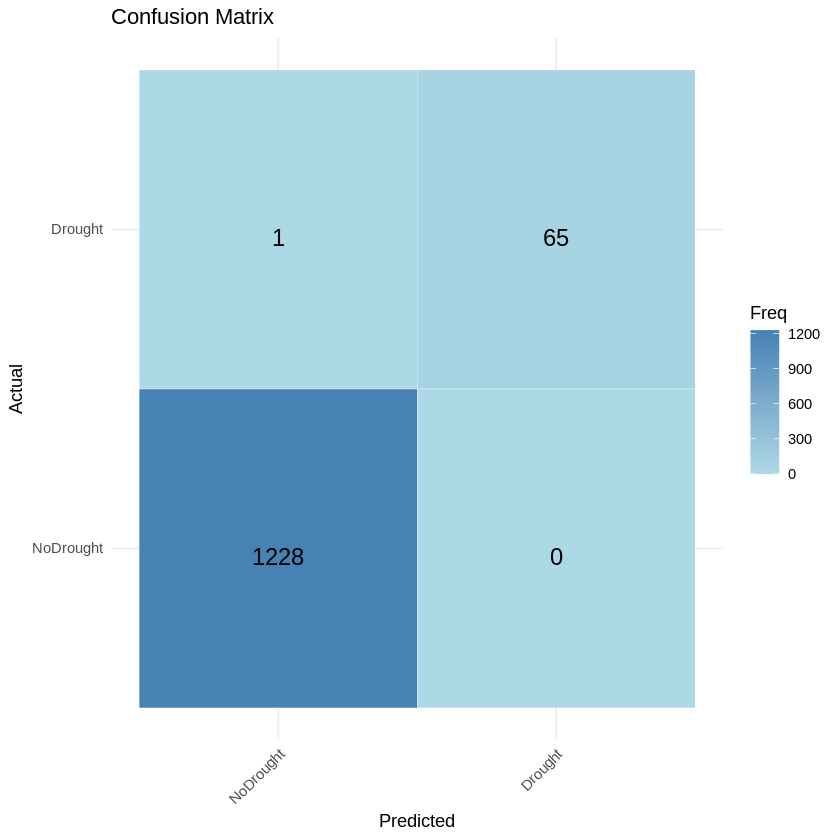

In [ ]:
# 13. Confusion Matrix Plot
# Using ggplot2 to recreate seaborn's heatmap style
cm_table <- as.data.frame(cm$table)
ggplot(data = cm_table, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Freq), vjust = 1, size = 5) +
  scale_fill_gradient(low = "lightblue", high = "steelblue") +
  labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
# To show plot immediately if running interactively:
# print(plt) # or just call the ggplot(...) directly

       Feature         Gain        Cover   Frequency
        <char>        <num>        <num>       <num>
 1:    Avg_Jun 8.971470e-01 2.556331e-01 0.143410853
 2:    L4_CODE 3.697127e-02 1.195137e-01 0.096899225
 3: 1998-11-01 2.769618e-02 1.117719e-01 0.079457364
 4: 1999-06-01 1.065077e-02 8.033111e-02 0.073643411
 5:    X_COORD 7.833470e-03 9.832456e-02 0.054263566
 6: 2009-11-01 1.995996e-03 7.005699e-02 0.021317829
 7:      TOT_P 1.970895e-03 5.570713e-02 0.034883721
 8: 1998-10-01 1.803179e-03 2.308894e-02 0.015503876
 9: 2000-07-01 1.749357e-03 2.194329e-03 0.052325581
10:    Y_COORD 1.594963e-03 3.413007e-03 0.023255814
11: 2008-07-01 1.210162e-03 5.966078e-03 0.040697674
12: 2000-06-01 1.057554e-03 8.462515e-03 0.013565891
13: 1998-07-01 1.045380e-03 2.956985e-03 0.036821705
14:      No_HH 9.155035e-04 2.218265e-02 0.009689922
15: 2010-06-01 8.955865e-04 2.683551e-02 0.025193798
16:   Avg_Sept 8.935917e-04 2.182398e-02 0.011627907
17: UNIRRIGATE 8.462540e-04 1.197907e-02 0.015

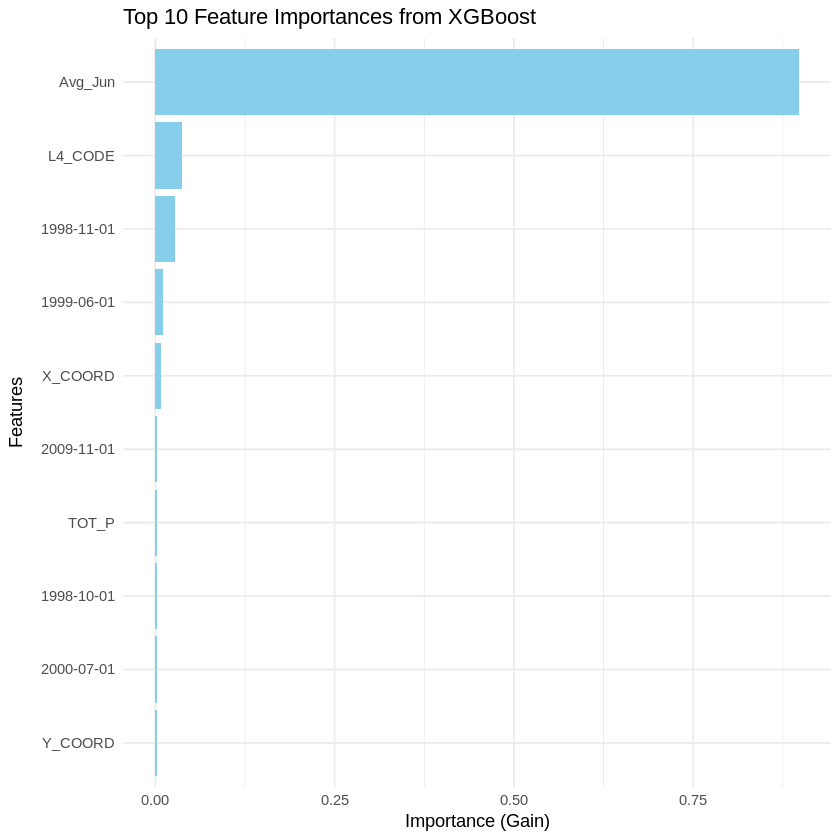

In [ ]:
# 14. Feature Importance (top 10 features)
importance_matrix <- xgb.importance(feature_names = colnames(X_train_scaled_matrix), model = model)
print(importance_matrix)

# Plot top 10 features
# xgb.plot.importance(importance_matrix = importance_matrix, top_n = 10, measure = "Gain") # Requires DiagrammeR
# Alternative with ggplot2:
importance_df <- as.data.frame(importance_matrix)
ggplot(head(importance_df, 10), aes(x = reorder(Feature, Gain), y = Gain)) +
  geom_bar(stat = "identity", fill = "skyblue") +
  coord_flip() + # Horizontal bars
  labs(title = "Top 10 Feature Importances from XGBoost",
       x = "Features",
       y = "Importance (Gain)") +
  theme_minimal()



Rows: 6470 Columns: 79
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): L0_NAME, L1_NAME, L2_NAME, L3_NAME, L4_NAME, ID, NAME, MAIN_CRO_1
dbl (70): Excel_ID, Y_COORD, X_COORD, L4_CODE, L0_CODE, L1_CODE, L2_CODE, L3...
lgl  (1): DISPUTE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


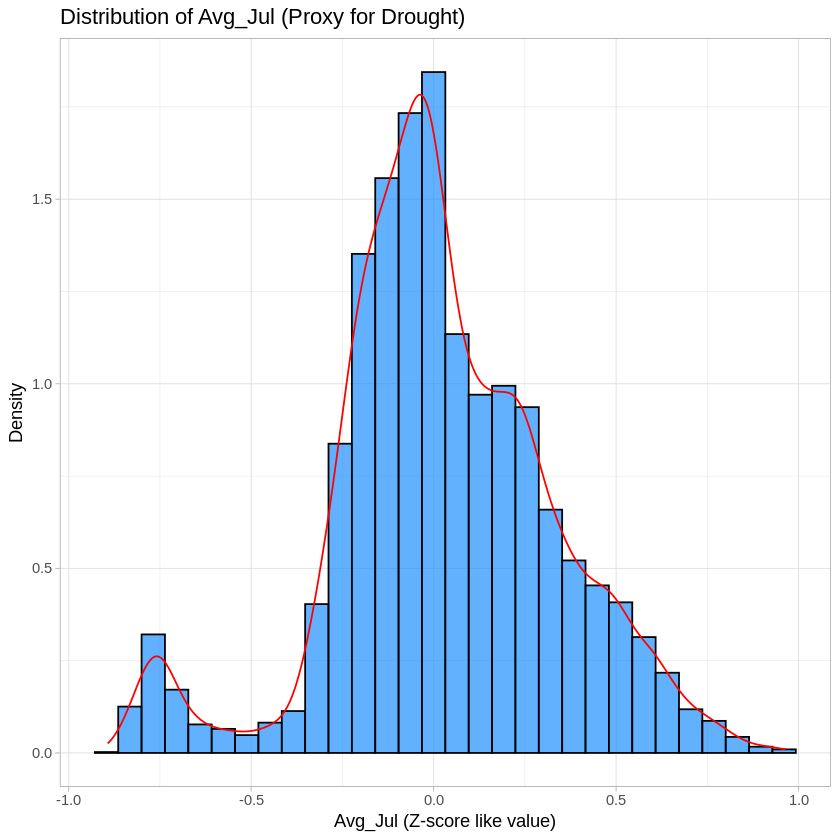

[1] "Columns for pairplot: 2009-06-01, 2009-07-01, 2009-08-01, 2009-09-01, 2009-10-01, DROUGHT_viz"


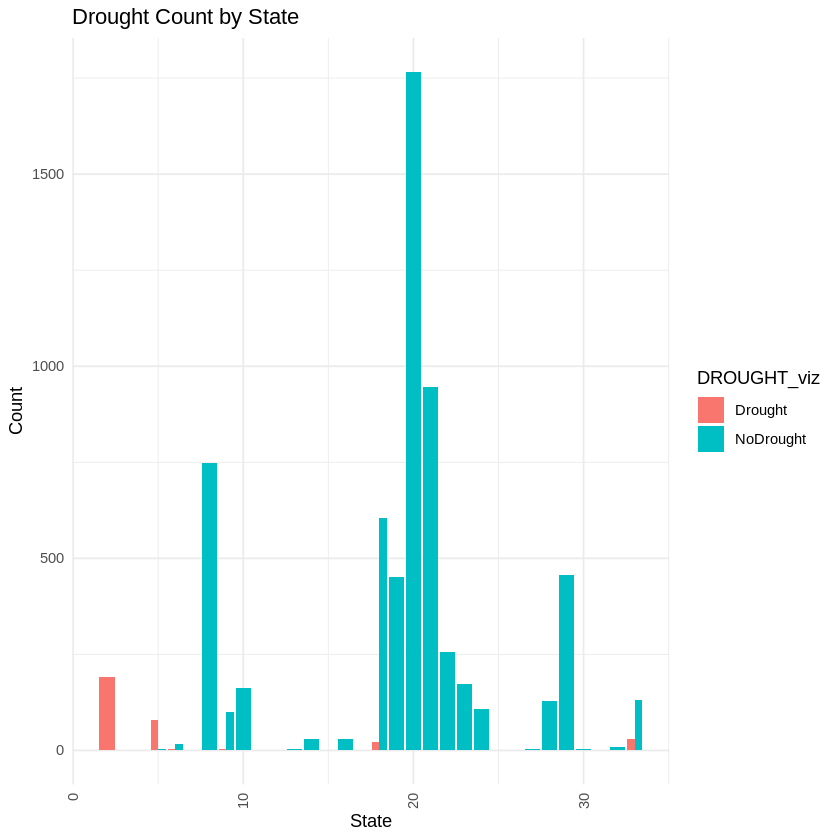

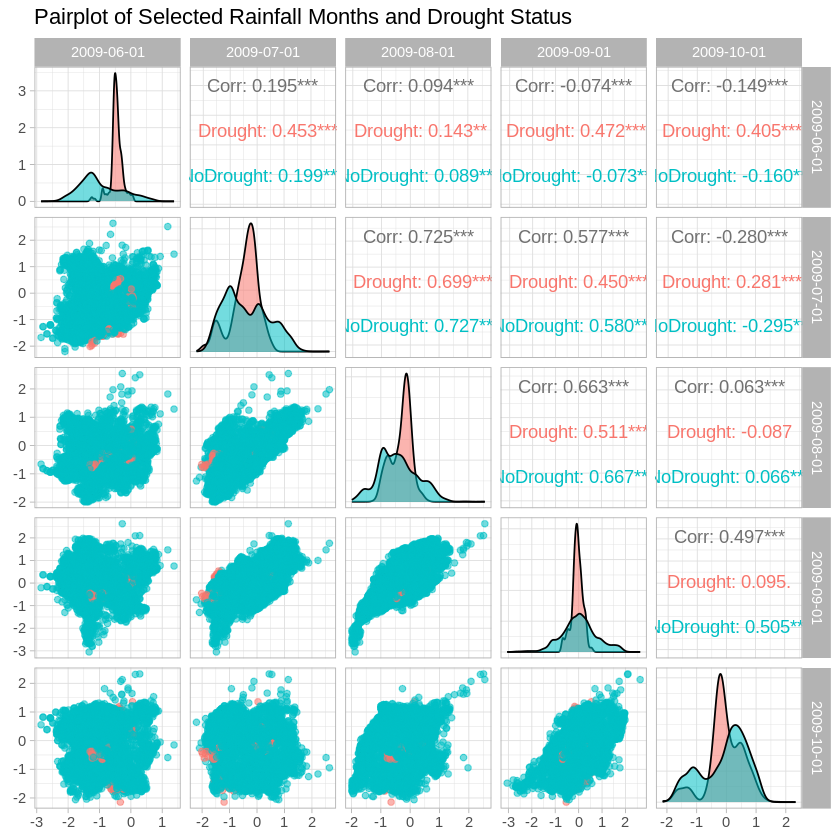

In [ ]:
# 15. EDA Visualizations
# Re-load original df or use a copy for EDA if df was heavily modified for modeling
df_eda <- read_csv('/drought_data.csv') # Or use the 'df' from before target creation if it still has 'Avg_Jul'

# Histogram of rainfall in July (using Avg_Jul as proxy for drought as in Python)
if ('Avg_Jul' %in% names(df_eda)) {
  ggplot(df_eda, aes(x = Avg_Jul)) +
    geom_histogram(aes(y = ..density..), bins = 30, fill = "dodgerblue", color = "black", alpha = 0.7) +
    geom_density(color = "red") +
    ggtitle("Distribution of Avg_Jul (Proxy for Drought)") +
    xlab("Avg_Jul (Z-score like value)") +
    ylab("Density") +
    theme_light()
  # print(p_hist_avg_jul)
} else if ('2010-07-01' %in% names(df_eda)) { # Fallback to a specific column if Avg_Jul was removed early
   # Ensure the column name is R-friendly or use backticks
   col_2010_07_01 <- "2010-07-01" # Store in a variable for easier use with backticks if needed
   ggplot(df_eda, aes(x = .data[[col_2010_07_01]])) + # Use .data[[...]] for string column names
     geom_histogram(aes(y = ..density..), bins = 30, fill = "dodgerblue", color = "black", alpha = 0.7) +
     geom_density(color = "red") +
     ggtitle(paste("Rainfall Distribution -", col_2010_07_01)) +
     xlab("Rainfall (Z-score)") +
     ylab("Density") +
     theme_light()
   # print(p_hist_july)
}


# Drought by State (if STATE exists in original data)
# This requires the 'DROUGHT' column to be added to df_eda based on 'Avg_Jul'
if ("Avg_Jul" %in% names(df_eda) && "STATE" %in% names(df_eda)) {
  df_eda_drought <- df_eda %>%
    mutate(DROUGHT_viz = factor(ifelse(Avg_Jul < -0.5, "Drought", "NoDrought")))

  ggplot(df_eda_drought, aes(x = STATE, fill = DROUGHT_viz)) +
    geom_bar(position = "dodge") +
    ggtitle("Drought Count by State") +
    xlab("State") +
    ylab("Count") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
  # print(p_drought_state)
}

# Pairplot of rainfall months
# First, ensure 'DROUGHT' is in df_eda for coloring, and select relevant columns
if ("Avg_Jul" %in% names(df_eda)) {
  df_eda <- df_eda %>%
    mutate(DROUGHT_viz = factor(ifelse(Avg_Jul < -0.5, "Drought", "NoDrought")))

  # Identify rainfall columns (adjust pattern as needed)
  # R doesn't like hyphens in names by default, read_csv might convert them to dots or use backticks
  # Assuming column names are like 'YYYY.MM.DD' or 'YYYY_MM_DD' if auto-corrected by R
  # Or use backticks if they are 'YYYY-MM-DD'
  # Let's find columns that look like dates based on the Python example
  rain_cols_pattern <- "^(2009|2010)-" # Original pattern
  # If read_csv converted '-' to '.', use:
  # rain_cols_pattern <- "^(2009|2010)\\."

  # Get actual column names matching pattern
  actual_rain_cols <- grep(rain_cols_pattern, names(df_eda), value = TRUE)

  if(length(actual_rain_cols) > 0) {
    cols_for_pairplot <- c(head(actual_rain_cols, 5), "DROUGHT_viz") # Take first 5 rain cols + target

    # Check if all selected columns exist
    cols_for_pairplot_exist <- cols_for_pairplot[cols_for_pairplot %in% names(df_eda)]

    if (length(cols_for_pairplot_exist) > 1 && "DROUGHT_viz" %in% cols_for_pairplot_exist) {
      print(paste("Columns for pairplot:", paste(cols_for_pairplot_exist, collapse=", ")))
      # Ensure numeric for ggpairs continuous plots, except the hue variable
      df_pairplot <- df_eda[, cols_for_pairplot_exist] %>%
        mutate(across(-DROUGHT_viz, as.numeric)) # Convert all but DROUGHT_viz to numeric

      ggpairs(df_pairplot,
              columns = which(names(df_pairplot) != "DROUGHT_viz"), # Columns to plot
              aes(color = DROUGHT_viz, alpha = 0.5),
              title = "Pairplot of Selected Rainfall Months and Drought Status") +
        theme_light()
      # print(p_pairplot)
    } else {
      print("Not enough columns for pairplot or DROUGHT_viz missing.")
    }
  } else {
    print("No rainfall columns found matching the pattern for pairplot.")
  }
}



In [ ]:
drought_count <- sum(y_pred_factor == "Drought")
no_drought_count <- sum(y_pred_factor == "NoDrought")

cat("\n🌾 ML-based Early Warning System for Drought in India\n")
cat("-------------------------------------------------------\n")
cat(sprintf("Total Regions Predicted: %d\n", length(y_pred_factor)))
cat(sprintf("🛑 Predicted Drought Conditions: %d\n", drought_count))
cat(sprintf("✅ Predicted No Drought Conditions: %d\n", no_drought_count))
cat("\n⚠️ This system uses historical drought and weather data to predict upcoming drought conditions.\n")
cat("🧠 Powered by XGBoost ML algorithm.\n")
cat("📢 Early warnings can help farmers prepare for water scarcity and crop planning in advance.\n\n")


🌾 ML-based Early Warning System for Drought in India
-------------------------------------------------------
Total Regions Predicted: 1294
🛑 Predicted Drought Conditions: 65
✅ Predicted No Drought Conditions: 1229

⚠️ This system uses historical drought and weather data to predict upcoming drought conditions.
🧠 Powered by XGBoost ML algorithm.
📢 Early warnings can help farmers prepare for water scarcity and crop planning in advance.

